In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import jupyter_black

jupyter_black.load()

In [2]:
import os

print(os.getcwd())

/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Notebooks


In [3]:
df_customer_Churn = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/Daily_Churned_customers_JET.csv"
)

df_input_accounts = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/input_accounts_21_10_2022.csv"
)

df_tweets = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/tweets-2022-10-21_justeattakeaway.csv"
)

In [4]:
df_tweets = pd.merge(
    left=df_tweets,
    right=df_input_accounts,
    left_on="user_id",
    right_on="user_id",
    how="left",
)
df_input_accounts = None

## Only get english Tweets

In [5]:
# delta chrun
df_customer_Churn["d_churn"] = (
    df_customer_Churn["Churned customers"].shift(1)
    - df_customer_Churn["Churned customers"]
)

# Part 2. Data analysis of the platform’s Twitter data

## data Preprocessing

##### 1. Remove all non-character signs and stop words (Stop words are a set of commonly used words in a language that do not have any meaning. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.):

In [6]:
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [7]:
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import CountVectorizer
from termcolor import colored
import math

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize


import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
def show_vocabulary(vectorizer, word_size=15, words_per_line=10):
    words = vectorizer.get_feature_names()

    print(f"Vocabulary size: {len(words)} words")

    word_format = f"<{word_size}"
    for l in np.array_split(words, math.ceil(len(words) / words_per_line)):
        print("".join([f"{x:{word_format}}" for x in l]))


def show_bow(vectorizer, bow, word_size=15, words_per_line=8):
    words = vectorizer.get_feature_names()

    word_format = f"<{word_size}"
    for l in np.array_split(
        list(zip(words, bow)), math.ceil(len(words) / words_per_line)
    ):
        print(
            " | ".join(
                [
                    colored(f"{w:{word_format}}:{n:>2}", "grey")
                    if int(n) == 0
                    else colored(
                        f"{w:{word_format}}:{n:>2}",
                        on_color="on_yellow",
                        attrs=["bold"],
                    )
                    for w, n in l
                ]
            )
        )


def show_bow_float(vectorizer, bow, word_size=15, words_per_line=6):
    words = vectorizer.get_feature_names()

    word_format = f"<{word_size}"
    for l in np.array_split(
        list(zip(words, bow)), math.ceil(len(words) / words_per_line)
    ):
        print(
            " | ".join(
                [
                    colored(f"{w:word_format}:{float(n):>0.2f}", "grey")
                    if float(n) == 0
                    else colored(
                        f"{w:word_format}:{float(n):>0.2f}",
                        on_color="on_yellow",
                        attrs=["bold"],
                    )
                    for w, n in l
                ]
            )
        )

In [9]:
additional = ["rt", "rts", "retweet", "please", "ha"]  # we'll store additional stopwords here
swords = set().union(stopwords.words("english"), additional)

# replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_tweets.drop_duplicates(subset="text", inplace=True)
df_tweets["text"] = df_tweets["text"].str.lower()

df_tweets["processed_text"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
    .apply(lambda x: [i for i in x.split() if not i in swords])
)

df_tweets["processed_text_"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
)

/tmp/ipykernel_54539/1926634214.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]
/tmp/ipykernel_54539/1926634214.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]


In [10]:
wnl = WordNetLemmatizer()


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        regex_num_ponctuation = "(\d+)|([^\w\s])"
        regex_little_words = r"(\b\w{1,2}\b)"
        regex_smiley = "(@[a-z0-9]+)\w+"
        regex_signs = "(http\S+)"
        regex_tweet_spec = "([^0-9a-z \t])"
        regex_https = " +"
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if not re.search(regex_num_ponctuation, t)
            and not re.search(regex_smiley, t)
            and not re.search(regex_signs, t)
            and not re.search(regex_tweet_spec, t)
            and not re.search(regex_little_words, t)
            and not re.search(regex_https, t)
        ]

In [11]:
df_tweets_jet = df_tweets[df_tweets.lang == "en"]

In [57]:
swords = set().union(stopwords.words("english"), additional)


count = CountVectorizer(
    stop_words=swords,
    tokenizer=LemmaTokenizer(),
    ngram_range=(1, 3),  # will create a vocabulary with 1-gram and 2-grams
    min_df=3,
    max_df=0.9,
    max_features=1000,
)


# count = CountVectorizer(
#     stop_words=swords,
#     tokenizer=LemmaTokenizer(),
#     ngram_range=(1, 3),  # will create a vocabulary with 1-gram and 2-grams
#     min_df=3,
#     max_df=0.9,
#     max_features=2000,
# )

matrix = count.fit_transform(df_tweets_jet.processed_text_)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())
results

/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(
/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,able drop,able drop order,able follow,able follow request,able get,able get back,able look,able place,able place order,...,yesterday sorry,yesterday sorry inconvenience,yet,yet account,yet account email,yet order,yet resolved,yet resolved account,young,young people
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14755,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())

In [59]:
K = 6

In [60]:
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

In [61]:
lda.print_topics()

[(0,
  '0.024*"closer" + 0.024*"closer look" + 0.024*"take" + 0.023*"take closer" + 0.023*"take closer look" + 0.021*"drop" + 0.018*"look" + 0.016*"would" + 0.014*"know" + 0.013*"eat"'),
 (1,
  '0.036*"soon" + 0.032*"email" + 0.024*"address" + 0.022*"detail" + 0.022*"email address" + 0.021*"pick" + 0.020*"sorry" + 0.020*"possible" + 0.020*"account" + 0.017*"soon possible"'),
 (2,
  '0.041*"order" + 0.038*"order number" + 0.036*"number" + 0.030*"hear" + 0.029*"hey" + 0.028*"thanks" + 0.026*"look" + 0.026*"like" + 0.020*"could" + 0.017*"thanks reaching"'),
 (3,
  '0.076*"support" + 0.036*"help" + 0.036*"team" + 0.035*"uber" + 0.034*"happy" + 0.033*"eats" + 0.033*"assist" + 0.033*"uber eats" + 0.032*"happy help" + 0.031*"support team"'),
 (4,
  '0.016*"com" + 0.015*"like" + 0.014*"reaching" + 0.013*"team" + 0.013*"hand" + 0.013*"email" + 0.013*"customer" + 0.012*"twitter com" + 0.011*"thank" + 0.011*"lend"'),
 (5,
  '0.030*"assist" + 0.030*"address" + 0.030*"email" + 0.030*"email address"

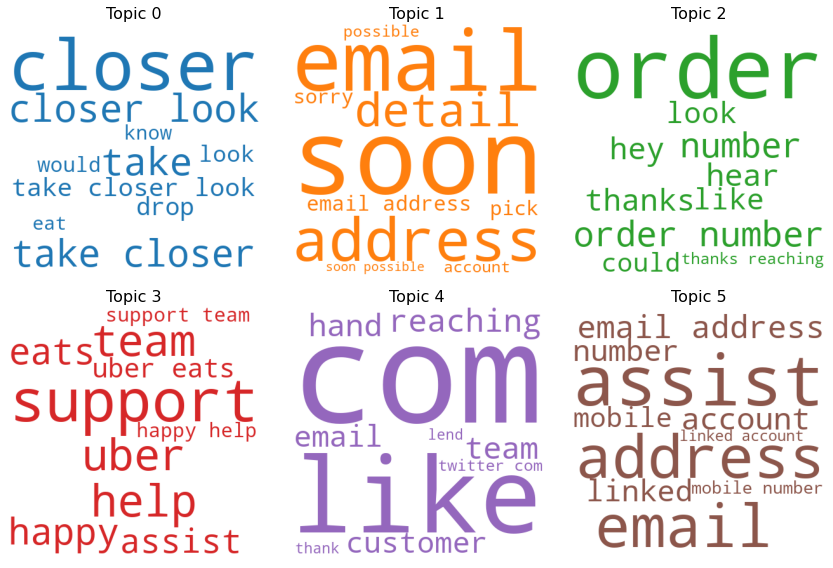

In [62]:
nb_columns = 3
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)

fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(i), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [63]:
# show_vocabulary(count)

In [64]:
lda.print_topics()

[(0,
  '0.024*"closer" + 0.024*"closer look" + 0.024*"take" + 0.023*"take closer" + 0.023*"take closer look" + 0.021*"drop" + 0.018*"look" + 0.016*"would" + 0.014*"know" + 0.013*"eat"'),
 (1,
  '0.036*"soon" + 0.032*"email" + 0.024*"address" + 0.022*"detail" + 0.022*"email address" + 0.021*"pick" + 0.020*"sorry" + 0.020*"possible" + 0.020*"account" + 0.017*"soon possible"'),
 (2,
  '0.041*"order" + 0.038*"order number" + 0.036*"number" + 0.030*"hear" + 0.029*"hey" + 0.028*"thanks" + 0.026*"look" + 0.026*"like" + 0.020*"could" + 0.017*"thanks reaching"'),
 (3,
  '0.076*"support" + 0.036*"help" + 0.036*"team" + 0.035*"uber" + 0.034*"happy" + 0.033*"eats" + 0.033*"assist" + 0.033*"uber eats" + 0.032*"happy help" + 0.031*"support team"'),
 (4,
  '0.016*"com" + 0.015*"like" + 0.014*"reaching" + 0.013*"team" + 0.013*"hand" + 0.013*"email" + 0.013*"customer" + 0.012*"twitter com" + 0.011*"thank" + 0.011*"lend"'),
 (5,
  '0.030*"assist" + 0.030*"address" + 0.030*"email" + 0.030*"email address"

In [65]:
names = ["Rugby", "Video Games", "Radio", "Internet", "Politics", "Cybersecurity"]

topic_names = {i: v for i, v in enumerate(names)}

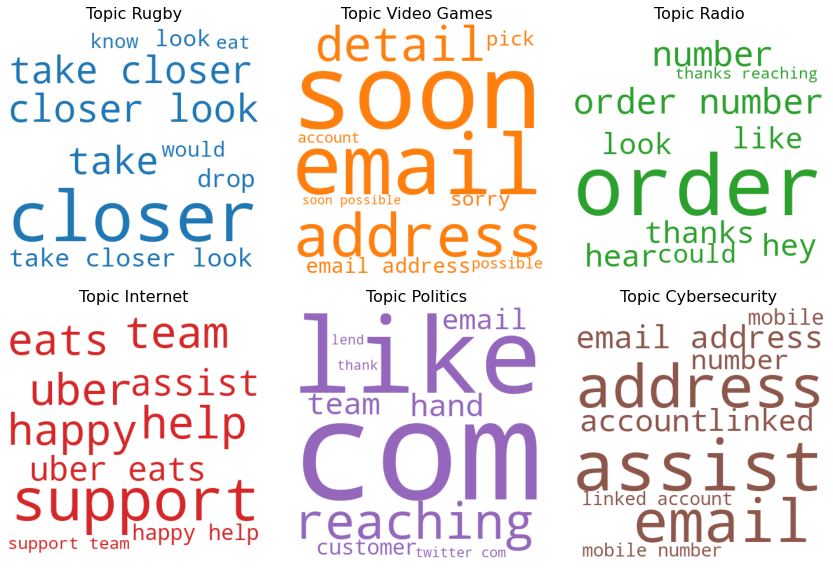

In [66]:
nb_columns = 3
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(names[i]), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Answering 2.1 

In [67]:
# most important topics
lda.print_topics()

[(0,
  '0.024*"closer" + 0.024*"closer look" + 0.024*"take" + 0.023*"take closer" + 0.023*"take closer look" + 0.021*"drop" + 0.018*"look" + 0.016*"would" + 0.014*"know" + 0.013*"eat"'),
 (1,
  '0.036*"soon" + 0.032*"email" + 0.024*"address" + 0.022*"detail" + 0.022*"email address" + 0.021*"pick" + 0.020*"sorry" + 0.020*"possible" + 0.020*"account" + 0.017*"soon possible"'),
 (2,
  '0.041*"order" + 0.038*"order number" + 0.036*"number" + 0.030*"hear" + 0.029*"hey" + 0.028*"thanks" + 0.026*"look" + 0.026*"like" + 0.020*"could" + 0.017*"thanks reaching"'),
 (3,
  '0.076*"support" + 0.036*"help" + 0.036*"team" + 0.035*"uber" + 0.034*"happy" + 0.033*"eats" + 0.033*"assist" + 0.033*"uber eats" + 0.032*"happy help" + 0.031*"support team"'),
 (4,
  '0.016*"com" + 0.015*"like" + 0.014*"reaching" + 0.013*"team" + 0.013*"hand" + 0.013*"email" + 0.013*"customer" + 0.012*"twitter com" + 0.011*"thank" + 0.011*"lend"'),
 (5,
  '0.030*"assist" + 0.030*"address" + 0.030*"email" + 0.030*"email address"

In [68]:
by_get_document_topics = list(map(lda.get_document_topics, corpus))

by_bracket = lda[corpus]

##### most used words / hashtags / bigrams (trigrams)?

In [69]:
# most fequent words and trigrams

# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_jet["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)


additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())

    counter += 1


df_results["length"] = additiona.values()
# load the topics by document!

/tmp/ipykernel_54539/3880368622.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_jet["processed_words_lemma"] = processed_words.values()


In [70]:
# most important single words
df_results.count_words.head(5)

# most improtant bigrams
df_results[df_results.length == 2].head(5)

# most important trigrams
df_results[df_results.length == 3].head(5)

,count_words,length
email address mobile,1337,3
address mobile number,1312,3
mobile number linked,1284,3
number linked account,1275,3
support team assist,1157,3


#### words by time of day

In [71]:
# time question
df_tweets_jet["created_at"] = pd.to_datetime(df_tweets_jet.created_at)

df_tweets_jet["year"] = pd.DatetimeIndex(df_tweets_jet.created_at).year
df_tweets_jet["month"] = pd.DatetimeIndex(df_tweets_jet.created_at).month
df_tweets_jet["day"] = pd.DatetimeIndex(df_tweets_jet.created_at).day
df_tweets_jet["hour"] = pd.DatetimeIndex(df_tweets_jet.created_at).hour

/tmp/ipykernel_54539/3441293956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_jet["created_at"] = pd.to_datetime(df_tweets_jet.created_at)
/tmp/ipykernel_54539/3441293956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_jet["year"] = pd.DatetimeIndex(df_tweets_jet.created_at).year
/tmp/ipykernel_54539/3441293956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [72]:
df_results

,count_words,length
order,3887,1
help,3561,1
email,3479,1
number,3408,1
assist,3061,1
...,...,...
offer new,21,2
dip,21,1
left,21,1
get spare,21,2


In [73]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score'],
      dtype='object')

In [74]:
# count number of tweets by company by hour of day/month
df_tweets_jet.groupby(by=["hour", "full_name"]).agg({"tweet_id": "count"})

tweet_id
hour full_name                      
0    Deliveroo                    21
     Just Eat Takeaway.com         3
     Uber Eats                    37
     Uber Eats UK                 21
1    Deliveroo                    14
...                              ...
22   Uber Eats UK                  5
23   Deliveroo                    30
     Just Eat Takeaway.com         3
     Uber Eats                    44
     Uber Eats UK                 14

[126 rows x 1 columns]

In [75]:
df_tweets_jet.groupby(by=["day", "full_name"]).agg({"tweet_id": "count"})

tweet_id
day full_name                      
1   Deliveroo                    78
    Just Eat Takeaway.com        85
    Just Eat UK                 296
    Thuisbezorgd.nl              10
    Uber Eats                   121
...                             ...
31  Just Eat Takeaway.com        36
    Just Eat UK                  41
    Thuisbezorgd.nl               2
    Uber Eats                    47
    Uber Eats UK                 53

[185 rows x 1 columns]

In [76]:
df_tweets_jet.groupby(by=["month", "full_name"]).agg({"tweet_id": "count"})

tweet_id
month full_name                      
1     Just Eat Takeaway.com       172
      Thuisbezorgd.nl              17
      Uber Eats                   153
      Uber Eats UK                225
2     Just Eat Takeaway.com       173
      Thuisbezorgd.nl              15
      Uber Eats                   277
      Uber Eats UK                361
3     Deliveroo                   205
      Just Eat Takeaway.com       233
      Thuisbezorgd.nl               5
      Uber Eats                   244
      Uber Eats UK                524
4     Deliveroo                   400
      Just Eat Takeaway.com       243
      Thuisbezorgd.nl               3
      Uber Eats                   207
      Uber Eats UK                375
5     Deliveroo                   434
      Just Eat Takeaway.com       224
      Thuisbezorgd.nl              13
      Uber Eats                   152
      Uber Eats UK                225
6     Deliveroo                   399
      Just Eat Takeaway.com       224
      Thuisbezorgd.nl              12
      Uber Eats                   267
      Uber Eats UK                272
7     Deliveroo                   437
      Just Eat Takeaway.com       214
      Thuisbezorgd.nl               7
      Uber Eats                   420
      Uber Eats UK                186
8     Deliveroo                   427
      Just Eat Takeaway.com       148
      Just Eat UK                 210
      Thuisbezorgd.nl              17
      Uber Eats                   396
      Uber Eats UK                154
9     Deliveroo                   263
      Just Eat Takeaway.com       178
      Just Eat UK                1586
      Thuisbezorgd.nl              28
      Uber Eats                   381
      Uber Eats UK                179
10    Deliveroo                   221
      Just Eat Takeaway.com       201
      Just Eat UK                1372
      Thuisbezorgd.nl              39
      Uber Eats                   221
      Uber Eats UK                313
11    Just Eat Takeaway.com       238
      Thuisbezorgd.nl              26
      Uber Eats                   119
      Uber Eats UK                193
12    Just Eat Takeaway.com       185
      Thuisbezorgd.nl              15
      Uber Eats                   111
      Uber Eats UK                218

Goal from here on: make linegraphs showing the development of each company and also show the words used by company or in aggegate


additionally, use the topics labelled above and look at how the different companies stack up (eg one company might have problems with the customer service so they load more frequrently on this )

also words by topic




In [77]:
df_tweets_jet

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,user_name,full_name,processed_text,processed_text_,processed_words_lemma,year,month,day,hour,sentiment_score
0,1582838135704408066,3100005042,@foodnetwork flats for the win,1582759396047982592,2022-10-19 20:56:33+00:00,2022-10-21T11:13:50.000Z,2.071081e+07,en,NaN,False,...,UberEats,Uber Eats,"[flats, win]",flats for the win,[win],2022,10,19,20,0.0000
1,1582819451350945792,3100005042,@poptartsus that's too many flavors at once bro 🤔,1582809043198152704,2022-10-19 19:42:19+00:00,2022-10-21T11:13:50.000Z,1.613760e+08,en,NaN,False,...,UberEats,Uber Eats,"[many, flavors, bro]",that s too many flavors at once bro,[many],2022,10,19,19,0.0000
2,1582818118396973057,3100005042,@auntieannes retweet.,1582813881185239041,2022-10-19 19:37:01+00:00,2022-10-21T11:13:50.000Z,3.573787e+07,en,NaN,False,...,UberEats,Uber Eats,[],retweet,[],2022,10,19,19,0.0000
3,1582815779531079680,3100005042,@_mariegrey is ur refrigerator running because...,1582800989068746753,2022-10-19 19:27:43+00:00,2022-10-21T11:13:50.000Z,7.454956e+08,en,NaN,False,...,UberEats,Uber Eats,"[mariegrey, ur, refrigerator, running, lol, jk...",mariegrey is ur refrigerator running because ...,"[addition, ahead, back, free, great, happy, he...",2022,10,19,19,1.7074
4,1582798930630189057,3100005042,@drizly extra points for putting more water in...,1582763258963931136,2022-10-19 18:20:46+00:00,2022-10-21T11:13:50.000Z,9.440427e+08,en,NaN,False,...,UberEats,Uber Eats,"[extra, points, putting, water, bowl, cheers]",extra points for putting more water in their ...,[extra],2022,10,19,18,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18529,1426954857538260993,21427907,"@pachatka hi masha, unfortunately, that looks ...",1426954574871605253,2021-08-15 17:12:04+00:00,2022-10-21T11:15:36.000Z,2.972970e+08,en,NaN,False,...,thuisbezorgd,Thuisbezorgd.nl,"[hi, masha, unfortunately, looks, like, pizza,...",hi masha unfortunately that looks like a pizz...,"[could, eva, like, look, look like, pizza, sho...",2021,8,15,17,0.3612
18530,1426931682486128642,21427907,@vrijheidradio @be_cashy @kimdotcom @wthigoius...,1426337270412374018,2021-08-15 15:39:58+00:00,2022-10-21T11:15:36.000Z,1.575976e+09,en,NaN,False,...,thuisbezorgd,Thuisbezorgd.nl,"[hi, bitcoin, always, option, platform, possib...",hi bitcoin has always been the only option on...,"[always, ha, inconvenience, isabel, option, pa...",2021,8,15,15,-0.2011
18573,1425519979026427904,21427907,"@libranavi hi avi, feel free to shoot me a dm ...",1425519274911748099,2021-08-11 18:10:22+00:00,2022-10-21T11:15:36.000Z,8.309962e+07,en,NaN,False,...,thuisbezorgd,Thuisbezorgd.nl,"[hi, avi, feel, free, shoot, dm, information, ...",hi avi feel free to shoot me a dm with more i...,"[eva, feel, feel free, free, help, information...",2021,8,11,18,3.7357
18583,1424790126740312075,21427907,@garrkar @rozbeef85 i am sorry to hear that yo...,1412819657099296770,2021-08-09 17:50:12+00:00,2022-10-21T11:15:36.000Z,9.926927e+17,en,NaN,False,...,thuisbezorgd,Thuisbezorgd.nl,"[sorry, hear, waiting, team, still, currently,...",i am sorry to hear that you have been waiting...,"[able, add, apology, back, card, currently, he...",2021,8,9,17,-0.0236


In [78]:
# count words by hour of day and take max words at time of day/month
df_tweets_jet.processed_words_lemma

0                                                    [win]
1                                                   [many]
2                                                       []
3        [addition, ahead, back, free, great, happy, he...
4                                                  [extra]
                               ...                        
18529    [could, eva, like, look, look like, pizza, sho...
18530    [always, ha, inconvenience, isabel, option, pa...
18573    [eva, feel, feel free, free, help, information...
18583    [able, add, apology, back, card, currently, he...
18591    [busy, close, delivery, delivery driver, drive...
Name: processed_words_lemma, Length: 14757, dtype: object

## 2.2 Please, compute the sentiment scores for each tweet using nltk (vader) library or any other library of your choice. You may also engineer any additional variables based on computed sentiment scores. How could you describe the platform’s tweets based on their sentiment scores? (1 slide)

here we should find the sentiment score of each document; classify it and then build a regression on this 

In [79]:
import nltk.sentiment.vader as vd
from nltk import download

download("vader_lexicon")

sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

df_tweets_jet["sentiment_score"] = df_tweets_jet["processed_words_lemma"].apply(
    lambda x: sum(
        [sia.polarity_scores(i)["compound"] for i in word_tokenize(" ".join(x))]
    )
)
df_tweets_jet[["processed_words_lemma", "sentiment_score"]].head(n=10)
df_tweets_jet["sentiment_score"].apply(
    lambda x: round(
        x,
    )
).value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipykernel_54539/2022337429.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_jet["sentiment_score"] = df_tweets_jet["processed_words_lemma"].apply(


 0     5932
 1     2512
 2     1499
 6     1262
 8     1130
 3      651
 4      541
 5      523
 7      278
-1      215
 9      125
 10      42
 11      41
-2        6
Name: sentiment_score, dtype: int64

In [80]:
df_tweets_jet.sentiment_score.min()

-1.8802000000000003

plot the sentiment score distribution

In [81]:
df_tweets_jet.sentiment_score

0        0.5859
1        0.0000
2        0.0000
3        1.7074
4        0.0000
          ...  
18529    0.0424
18530   -0.6395
18573    3.3957
18583   -0.0236
18591    0.2475
Name: sentiment_score, Length: 14757, dtype: float64

#### create a 3-4 class sentiment score  (-2 to 0 is not good; etc)

#### group by company by sentiment scorem

#### see how the sentiment socre develops over time per comapny

### 3 What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet?




What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet?

#### Dependent variable preparation
As dependent variables, you may use the number of likes, retweets and / or replies to each tweet of the platform.

#### Create dummy per company

#### Create independent variable

### Create an aggregated user engagement variable for the outcome

As independent variables, you may use any relevant features from the Twitter data set, any additional features you created, and the sentiment scores from point 2.2 

### 3.1 Is the use of positive / negative emotional words in the company’s tweets (original posts or replies) related to higher / lower user engagement as measured by the number of  likes, retweets? (1 slide)


##### sentiment scores?

In [56]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score'],
      dtype='object')

### 3.2 Do your findings hold for any time period or can you observe any outstanding time or seasonal patterns? For your analysis you may check any periods of interest, for example, covid-19 lockdowns, summer months, holidays, weekly patterns, time of the day patterns. (1 slide)

Create: winter, summer, dummies

#### subset regression on different time of the year (summer vs winter ) but also a normal plot should help here!

### 3.3 Please, check whether user engagement with tweets of JustEatTakeaway.com is associated (or correlated) with customer churn? Do you observe any temporal patterns in this association, i.e. does this association differ depending what period you consider? How can you interpret the observed associations? (1 slide)


Create: winter, summer, dummies!! use interaction analysis!

Create an aggregated user engagement variable for the outcome
### use the cahnge in customer churn here as well

#### regression of engagement with 

In [82]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score'],
      dtype='object')

In [83]:
df_tweets_jet.processed_words_lemma

0                                                    [win]
1                                                   [many]
2                                                       []
3        [addition, ahead, back, free, great, happy, he...
4                                                  [extra]
                               ...                        
18529    [could, eva, like, look, look like, pizza, sho...
18530    [always, ha, inconvenience, isabel, option, pa...
18573    [eva, feel, feel free, free, help, information...
18583    [able, add, apology, back, card, currently, he...
18591    [busy, close, delivery, delivery driver, drive...
Name: processed_words_lemma, Length: 14757, dtype: object